### Use Markov Assumption to Build a MLP Model

In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

torch.Size([1000])


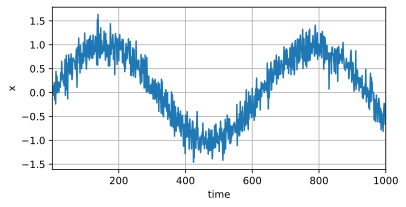

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)

# x = torch.sin(0.01 * time)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
print(x.shape)

d2l.plot(time, [x], xlabel='time', ylabel='x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))  # (996, 4) = (samples num, features num)
for i in range(tau):
    features[:, i] = x[i:i + T - tau]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600  # the first 600 points to be used to train
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), 
                            batch_size, is_train=True)

### Initialize the Weights of the Network

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

### Define a Simple MLP and Loss Function

In [5]:
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10 ,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()  # this is a 'regression problem', we choose MSELoss

### Train

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.060804
epoch 2, loss: 0.052824
epoch 3, loss: 0.053374
epoch 4, loss: 0.052084
epoch 5, loss: 0.053839


### Prediction the next One Step of Time

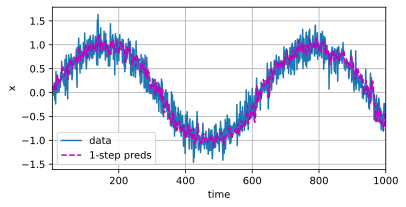

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], xlabel='time', ylabel='x',
         legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
        )

# we cannot predict the noise part, and now it is relatively accurate
# since we use 4 true points to predict 1 future point

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]

for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

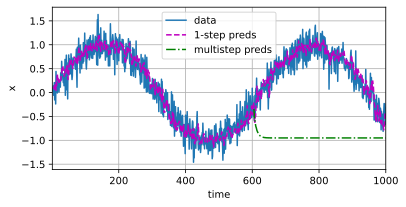

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(),
         multistep_preds[n_train + tau:].detach().numpy()], 
         xlabel='time', ylabel='x', 
         legend=['data', '1-step preds', 'multistep preds'], 
         xlim=[1, 1000], figsize=(6, 3)
        )

# the result is very bad 
# since the error is cumulative

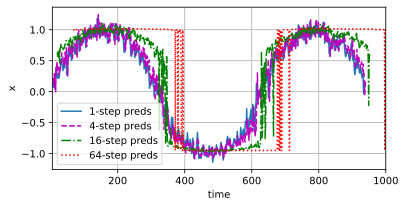

In [14]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# change 'i + T - tau' to 'i + T - tau - max_steps + 1'
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
         xlabel='time', ylabel='x',
         legend=[f'{i}-step preds' for i in steps], 
         xlim=[5, 1000], figsize=(6, 3)
        )

# blue line is a 1-point prediction based on 4 real points
# peach red line is a 4-point prediction based on 4 real points
# green line is a 16-point prediction based on 4 real points
# red line is a 64-point prediction based on 4 real points